# Import libraries

In [30]:
import scipy.io
from collections import Counter
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix , recall_score , precision_score , roc_auc_score , roc_curve ,log_loss , classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# Getting the labels that have the most images 

In [31]:
classes = []
labels_data = scipy.io.loadmat('imagelabels.mat')
labels = labels_data['labels'][0]
label_counts = Counter(labels)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
for i, (label, count) in enumerate(sorted_labels[:5], start=1):
    classes.append(label)
filtered_indices = [i for i, label in enumerate(labels) if label in classes]

# Image processing using pillow library

In [32]:
image_dir = "jpg"
images = []
filtered_labels = []

for idx in filtered_indices:
    img_path = os.path.join(image_dir, f'image_{idx+1:05d}.jpg')
    img = Image.open(img_path).resize((128, 128))
    images.append(np.array(img) / 255.0)
    filtered_labels.append(labels[idx])

images = np.array(images)


# Split the data into train and test 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(images, filtered_labels, test_size=0.2, random_state=3)

# Flatten the data

In [34]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print(X_test_flat.shape)
print(X_train_flat.shape)


(217, 49152)
(866, 49152)


# Train and test the model

In [35]:
# Train the logestic model
log_reg = LogisticRegression()
log_reg.fit(X_train_flat, y_train)
# Test the model
y_pred_log = log_reg.predict(X_test_flat)

# Calculating the evaluation matrics

In [36]:
report_log = classification_report(y_test, y_pred_log)
print(report_log)
recall_log = recall_score(y_test, y_pred_log, average='weighted')
print(f"KNN Recall: {recall_log:.4f}")
precision_log = precision_score(y_test, y_pred_log, average='weighted')
print(f"KNN Precision: {precision_log:.4f}")
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"KNN Accuracy: {accuracy_log:.4f}")

              precision    recall  f1-score   support

          46       0.79      0.80      0.80        41
          51       0.65      0.74      0.69        53
          73       0.69      0.71      0.70        35
          77       0.86      0.72      0.79        58
          89       0.73      0.73      0.73        30

    accuracy                           0.74       217
   macro avg       0.74      0.74      0.74       217
weighted avg       0.75      0.74      0.74       217

KNN Recall: 0.7419
KNN Precision: 0.7497
KNN Accuracy: 0.7419


# Confusion matrix

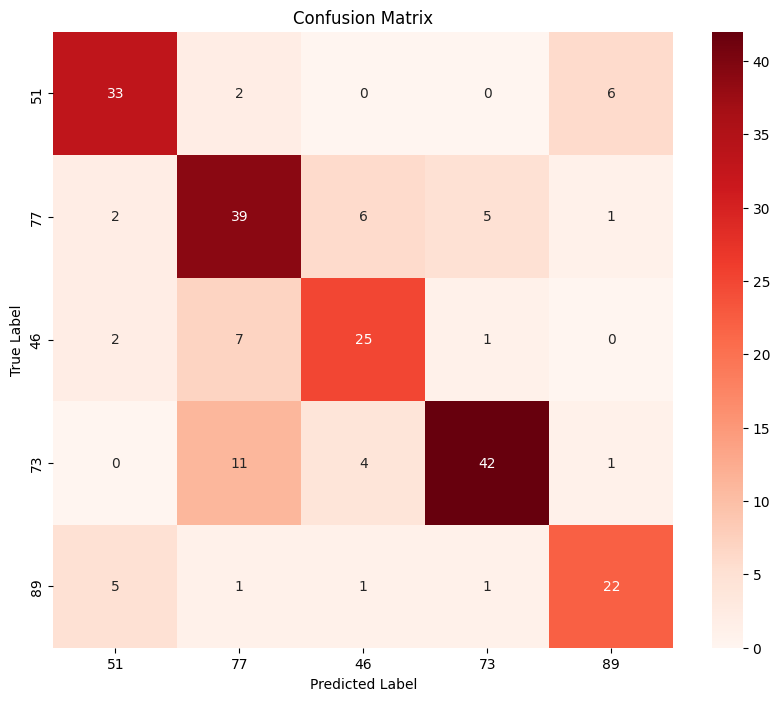

In [37]:
cm = confusion_matrix(y_test, y_pred_log)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels = classes, yticklabels = classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve and AUC values

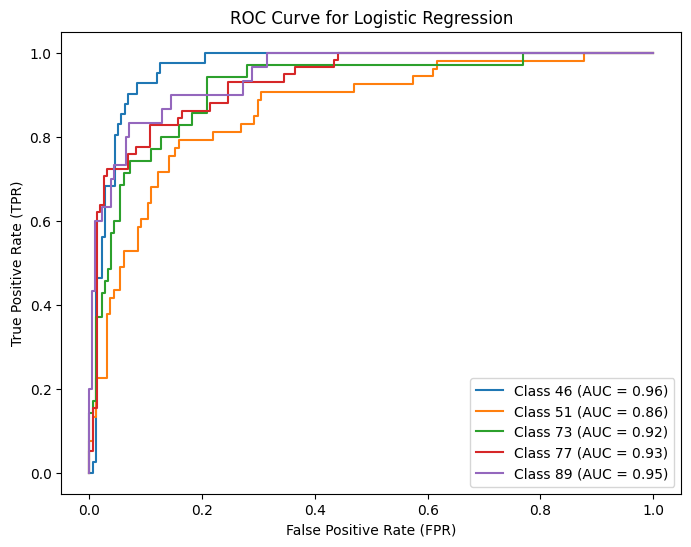

Average AUC: 0.9216
Loss : 1.4224


In [41]:
y_prob_log = log_reg.predict_proba(X_test_flat)

# Binarize the labels for multi-class ROC
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Plotting the ROC curve for each class and calculating the AUC (Area Under Curve)
plt.figure(figsize=(8, 6))
for i in range(len(log_reg.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_log[:, i])
    auc_value = roc_auc_score(y_test_bin[:, i], y_prob_log[:, i])
    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {auc_value:.2f})')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Calculate macro average AUC for multi-class
auc_value_overall = roc_auc_score(y_test_bin, y_prob_log, multi_class='ovr', average='weighted')
print(f"Average AUC: {auc_value_overall:.4f}")
loss = log_loss(y_test, y_prob_log , labels=classes)
print(f"Loss : {loss:.4f}")
